# kaggle 해커톤 . 6-2조
- 프로젝트 링크:
https://www.kaggle.com/c/competitive-data-science-predict-future-sales


## team
- 6-2조
- 이상국, 강명훈, 장선우

## 일정
### 1일차
- ~ : 각자 문제 및 데이터 파악
- 11:30 ~ : data 및 문제 관련 정의 (화상)
- ~ : 각자 진행
- 14:30 ~ : 진행 과정 토의1(화상) ex) 데이터 전처리, 모델정의
- ~ : 각자 진행   
- 17:00 ~ : 진행 과정 토의2(화상) , ex) 모델평가, 그리드서치, 앙상블, 모델개선 등..
- ~ 각자 진행   
<br/><br/>

### 2일차
- 10:00 ~ : 진행과정 토의3(화상),open meet
- ~ 각자 진행   
- 11:30 ~ : 제출 전 정리 미팅, 최고 스코어 도출
- ~ 각자 진행 또는 협업
- 14:00 ~ : 최종 제출

## 대회
- 2020.08.27(목)~2020.08.28(금) PM 2:00까지
- 캐글 Public Score 중 최고점을 슬랙 대회 채널에 jupyter notebook 파일과 함께 제출
- 제출 파일은 jupyter notebook이고,
- 형식은 Exploration 노드 과제 제출 형식과 동일합니다. (결과 출력, 로그 및 주요사항 reporting)

## 문제파악


### 디스크립션
- 러시아 최대 소프트웨어 회사 중 하나 인 1C Company 에서 친절하게 제공 한 일일 판매 데이터로 구성된 까다로운 시계열 데이터 세트


### file
- sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
- test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
- sample_submission.csv - a sample submission file in the correct format.
- items.csv - supplemental information about the items/products.
- item_categories.csv  - supplemental information about the items categories.
- shops.csv- supplemental information about the shops.

### filed 

- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- date_block_num==> 월 index data
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category

### 문제 정의
- 다음 달의 모든 제품 및 매장에 대한 총 매출을 예측

# library import

In [82]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error



#model 
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# hyper pram tuning library
from sklearn.model_selection import GridSearchCV

#time
import time

# data import

In [2]:
# data path set

data_dir = "./data"
train_data_path = join(data_dir, 'sales_train.csv') #train data
test_data_path = join(data_dir, 'test.csv') #test data

submission_path = join(data_dir, 'sample_submission.csv') #제출파일

categories_data_path = join(data_dir, 'item_categories.csv') #카테고리: 네임, 카테고리 아이디
items_path = join(data_dir, 'items.csv') # 아이템: 이름, id,  카테고리id
shops_path = join(data_dir, 'shops.csv') # 매장명: 매장명, id

# data import
origin_train = pd.read_csv(train_data_path)
origin_test = pd.read_csv(test_data_path)

submission_path = join(data_dir, 'sample_submission.csv') #제출파일

# 
categories= pd.read_csv(categories_data_path)
items = pd.read_csv(items_path)
shops = pd.read_csv(shops_path)



# data 파악

In [3]:
origin_train.shape

(2935849, 6)

In [4]:
origin_train.dtypes # column data type 조회

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

In [5]:
origin_train.head()
# 월 정보 index column

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [6]:
origin_test.head() # test data

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [7]:
categories.head() # 카테고리 파일

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [8]:
shops.head() # 매장 파일

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [9]:
items.head() # 아이템 제품 파일

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [10]:
## 매장별 월별 데이터

# data preprocessing

In [11]:
##
origin_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [12]:
train = origin_train.copy()
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


## 결측 데이터 숙청

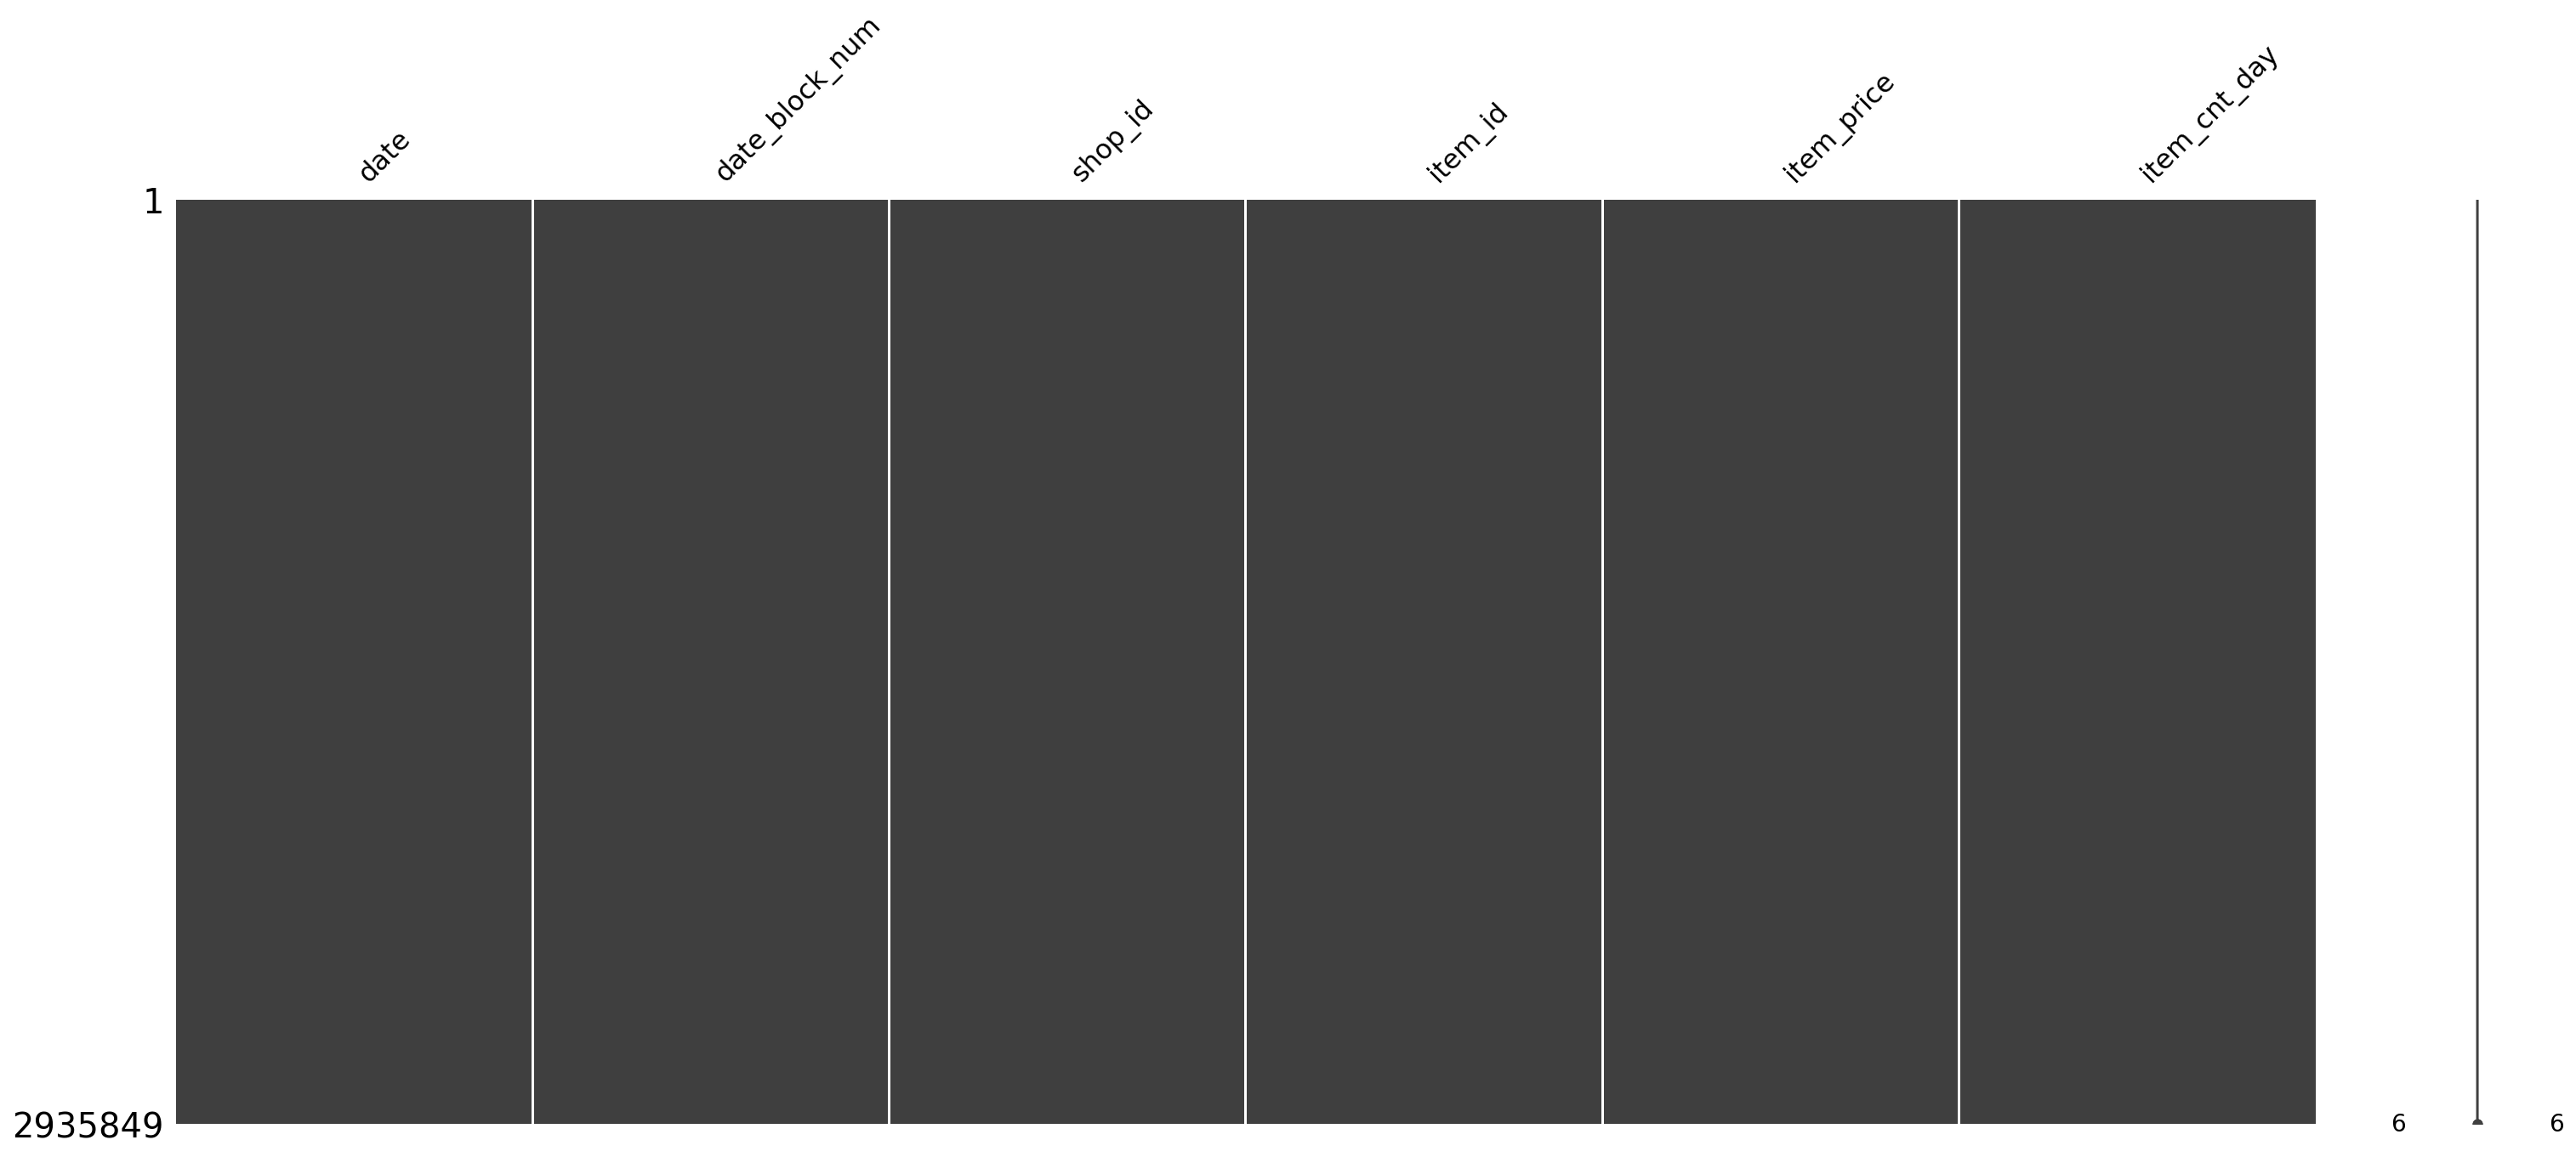

In [13]:
# 결측데이터 graph
msno.matrix(train)

In [14]:
print("------train data 결측------")
for c in train.columns:
    print('{} : {}'.format(c, len(train.loc[pd.isnull(train[c]), c].values)))
print("\n------test data 결측-------")
for c in train.columns:
    print('{} : {}'.format(c, len(train.loc[pd.isnull(train[c]), c].values)))

------train data 결측------
date : 0
date_block_num : 0
shop_id : 0
item_id : 0
item_price : 0
item_cnt_day : 0

------test data 결측-------
date : 0
date_block_num : 0
shop_id : 0
item_id : 0
item_price : 0
item_cnt_day : 0


In [15]:
#결측 데이더 없~~넹...

## 중복 데이터 숙청

In [16]:
train[train.duplicated()]
#6개 중복 데이터

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76962,05.01.2013,0,54,20130,149.0,1.0
1435367,23.02.2014,13,50,3423,999.0,1.0
1496766,23.03.2014,14,21,3423,999.0,1.0
1671873,01.05.2014,16,50,3423,999.0,1.0
1866340,12.07.2014,18,25,3423,999.0,1.0
2198566,31.12.2014,23,42,21619,499.0,1.0


In [17]:

def find_by_date_shopid_itemid(date, sid, iid):
    return train[(train['date'] == date)&(train['shop_id']==sid)&(train['item_id']==iid)]

d0 = find_by_date_shopid_itemid('05.01.2013', 54, 20130)
d1 = find_by_date_shopid_itemid('23.02.2014', 50, 3423)
d2 = find_by_date_shopid_itemid('23.03.2014', 21, 3423)
d3 = find_by_date_shopid_itemid('01.05.2014', 50, 3423)
d4 = find_by_date_shopid_itemid('12.07.2014', 25, 3423)
d5 = find_by_date_shopid_itemid('31.12.2014', 42, 21619)
print (d0)
print (d1)
print (d2)
print (d3)
print (d4)

             date  date_block_num  shop_id  item_id  item_price  item_cnt_day
76961  05.01.2013               0       54    20130       149.0           1.0
76962  05.01.2013               0       54    20130       149.0           1.0
               date  date_block_num  shop_id  item_id  item_price  \
1435365  23.02.2014              13       50     3423       999.0   
1435367  23.02.2014              13       50     3423       999.0   

         item_cnt_day  
1435365           1.0  
1435367           1.0  
               date  date_block_num  shop_id  item_id  item_price  \
1496765  23.03.2014              14       21     3423       999.0   
1496766  23.03.2014              14       21     3423       999.0   

         item_cnt_day  
1496765           1.0  
1496766           1.0  
               date  date_block_num  shop_id  item_id  item_price  \
1671872  01.05.2014              16       50     3423       999.0   
1671873  01.05.2014              16       50     3423       999.0   

In [18]:
#중복 데이터 숙청.
train.drop_duplicates(inplace=True)
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


## 이상치

### cnt_day , price

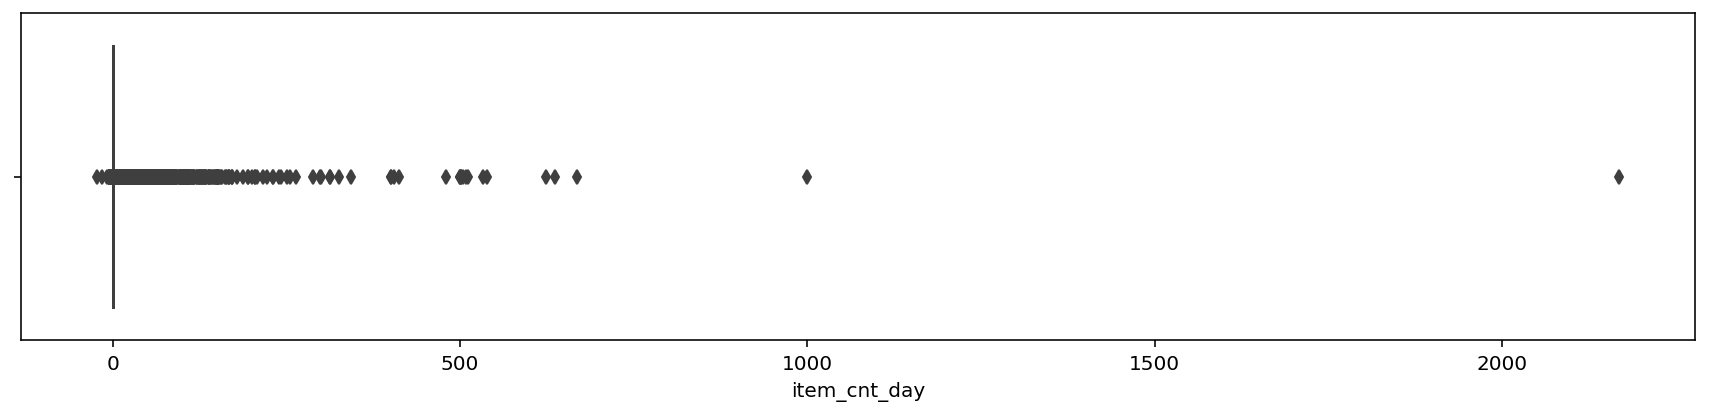

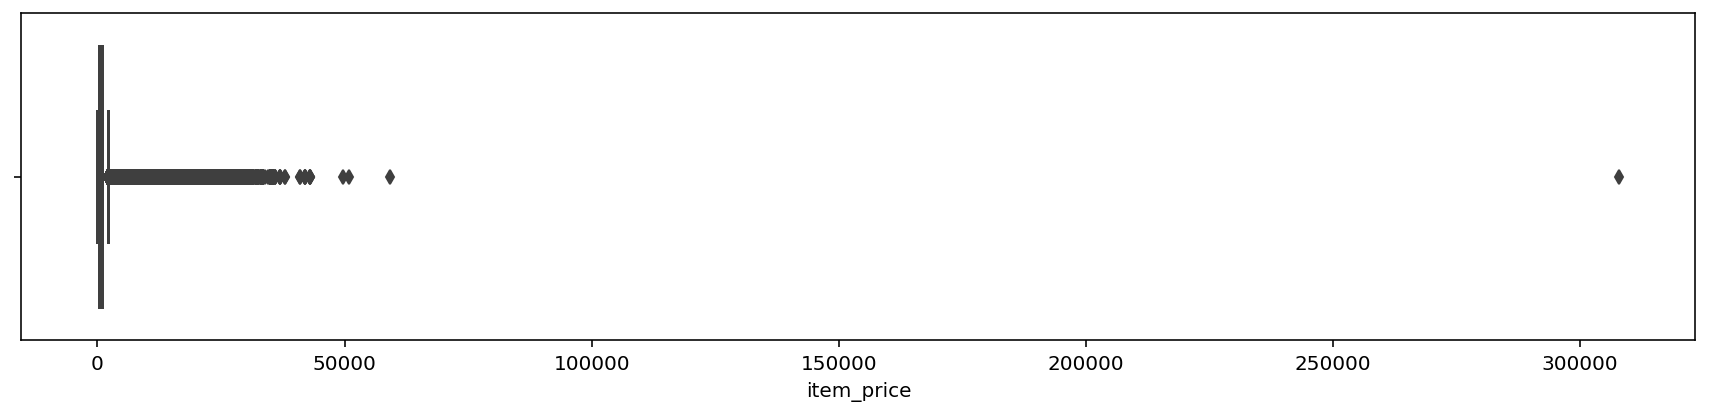

In [19]:
# 개수와 가격

plt.figure(figsize=(15,3))
sns.boxplot(x='item_cnt_day', data=train)

plt.figure(figsize=(15,3))
sns.boxplot(x='item_price', data=train);


In [20]:
#
train = train[train.item_cnt_day < 600]
train = train[train.item_price < 50000]
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


### data  (..)
 - 한 번에 요약된 통계 결과를 반환, 시리즈 혹은 데이터프레임의 각 열에 대한 요약 통계 

In [98]:
# data standardization
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,sales_day
count,2.928478e+06,2.928478e+06,2.928478e+06,2.928478e+06,2.928478e+06,2.928478e+06
mean,1.456974e+01,3.300298e+01,1.020028e+04,8.893248e+02,1.246599e+00,1.163069e+03
std,9.422946e+00,1.622542e+01,6.324395e+03,1.717569e+03,2.119974e+00,5.567446e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e-02,1.000000e+00,7.000000e-02
25%,7.000000e+00,2.200000e+01,4.477000e+03,2.490000e+02,1.000000e+00,2.490000e+02
50%,1.400000e+01,3.100000e+01,9.355000e+03,3.990000e+02,1.000000e+00,4.490000e+02
75%,2.300000e+01,4.700000e+01,1.569100e+04,9.990000e+02,1.000000e+00,1.090000e+03
max,3.300000e+01,5.900000e+01,2.216900e+04,4.978200e+04,5.390000e+02,1.829990e+06


In [97]:
train = train[train.item_cnt_day >= 0]
train = train[train.item_price >= 0]

### cnt_day 마이너스 데이터 처리(미적용)

- item_cnt_day < 0

In [99]:
train[train["item_cnt_day"] <0] # -data 조회

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,sales_day


In [23]:
# -데이터 처리 여부 ............ 결제 취소인가.... 위에 처리.


## 매출 데이터 생성(일 별)
- 가격 * 아이템 수

In [100]:
train['sales_day'] = train['item_price'] * train['item_cnt_day']
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,sales_day
0,02.01.2013,0,59,22154,999.00,1.0,999.00
1,03.01.2013,0,25,2552,899.00,1.0,899.00
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00
5,10.01.2013,0,25,2564,349.00,1.0,349.00
...,...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0,299.00
2935845,09.10.2015,33,25,7460,299.00,1.0,299.00
2935846,14.10.2015,33,25,7459,349.00,1.0,349.00
2935847,22.10.2015,33,25,7440,299.00,1.0,299.00


## 불필요 데이터 숙청
- date 의 날짜 제외

In [101]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,sales_day
0,02.01.2013,0,59,22154,999.00,1.0,999.00
1,03.01.2013,0,25,2552,899.00,1.0,899.00
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00
5,10.01.2013,0,25,2564,349.00,1.0,349.00


In [102]:
D_train = train.drop(['date','item_price','item_cnt_day'], axis=1, inplace=False)
D_train

,date_block_num,shop_id,item_id,sales_day
0,0,59,22154,999.00
1,0,25,2552,899.00
3,0,25,2554,1709.05
4,0,25,2555,1099.00
5,0,25,2564,349.00
...,...,...,...,...
2935844,33,25,7409,299.00
2935845,33,25,7460,299.00
2935846,33,25,7459,349.00
2935847,33,25,7440,299.00


## 월별 데이터로 그룹
- 매장별 아이템합 , 월별 그룹핑

In [103]:
# 그룹핑
G_train = D_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg('sum')

G_train.reset_index(inplace=True) # indexing
G_train = G_train.rename({'sales_day':'sales_month'}, axis='columns') # column 명 변경
G_train.columns

Index(['date_block_num', 'shop_id', 'item_id', 'sales_month'], dtype='object')

In [104]:
G_train.dtypes
G_train

,date_block_num,shop_id,item_id,sales_month
0,0,0,32,1326.0
1,0,0,33,1041.0
2,0,0,35,247.0
3,0,0,43,221.0
4,0,0,51,257.0
...,...,...,...,...
1608218,33,59,22087,714.0
1608219,33,59,22088,238.0
1608220,33,59,22091,179.0
1608221,33,59,22100,629.0


In [106]:
#카테고리 ID 붙여보기

In [125]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [130]:
# 컬럼 아이디만 붙이기
c_train = pd.merge(left=G_train, right=items[['item_category_id','item_id']], how="left", on='item_id', sort=False)
c_train

,date_block_num,shop_id,item_id,sales_month,item_category_id
0,0,0,32,1326.0,40
1,0,0,33,1041.0,37
2,0,0,35,247.0,40
3,0,0,43,221.0,40
4,0,0,51,257.0,57
...,...,...,...,...,...
1608218,33,59,22087,714.0,83
1608219,33,59,22088,238.0,83
1608220,33,59,22091,179.0,83
1608221,33,59,22100,629.0,42


In [131]:
# SHOP ID / ITEM ID 개수 / 카테고리 개수
len(c_train['shop_id'].value_counts()), len(c_train['item_id'].value_counts()),len(c_train['item_category_id'].value_counts())

(60, 21802, 84)

## 시계열 데이터 처리

## x train data 정리
- 매장별
- 월별
- 매출 : 판매수 * 가격

## y값 처리
- train 에서 y 값 도려내기
- y 값 분포 조정

In [ ]:
## 

# model 

# reference

- https://github.com/BaekKyunShin/Kaggle/blob/master/Predict_Future_Sales/Predict%20Future%20Sales.ipynb

- https://www.kaggle.com/jagangupta/time-series-basics-exploring-traditional-ts

# test

In [ ]:
origin_train.tail()

In [79]:
len(G_train['shop_id'].value_counts())

60

In [78]:
len(G_train['item_id'].value_counts())

21805

# comment